In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 2})
from scipy import stats
from loss import GAR, RnCLoss
from models import MLP
from utils import pair_dataset, set_all_seeds

# Sine Dataset

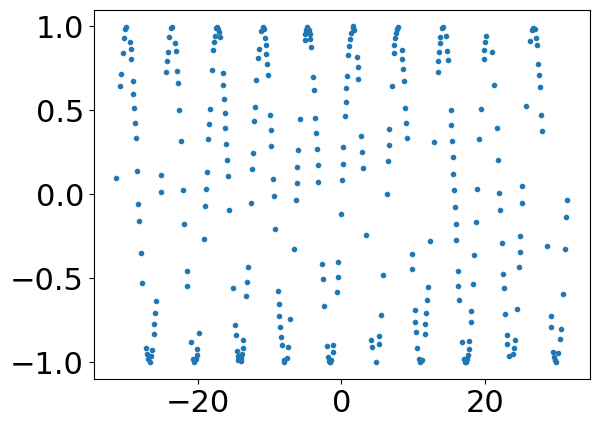

In [2]:
tmp = np.load('data/sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
plt.plot(trX, trY, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False, drop_last=False)
epochs = 300
milestones = [100, 200]

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GAR = []

alpha = 0.5

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR.append(pred_Y)
    
preds_GAR = np.concatenate(preds_GAR, axis=1)

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_RNC = []

for seed in seeds:
    set_all_seeds(seed)
    RNC = RnCLoss(temperature=4)
    basic_loss = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, feat = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            if epoch < 100:
                loss = RNC(feat, tr_Y)
            else:
                loss = basic_loss(pred_Y, tr_Y)
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, feat = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, feat = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='RNC')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='RNC')
    plt.legend()

    preds_RNC.append(pred_Y)
    
preds_RNC = np.concatenate(preds_RNC, axis=1)

In [ ]:
lr = 0.01
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    
preds_Pearson = np.concatenate(preds_Pearson, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    
preds_MAE = np.concatenate(preds_MAE, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    
preds_MSE = np.concatenate(preds_MSE, axis=1)

In [ ]:
np.savez('data/sine_results.npz',preds_GAR=preds_GAR, preds_RNC=preds_RNC, preds_Pearson=preds_Pearson, preds_MAE=preds_MAE, preds_MSE=preds_MSE)

In [ ]:
tmp = np.load('data/sine_results.npz')
MSE, MAE, APearson, RNC, GAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_GAR']


mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_MSE.pdf',format='pdf')


mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_MAE.pdf',format='pdf')


mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_APearson.pdf',format='pdf')


mean_GAR = GAR.mean(axis=1)
std_GAR = GAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label='GAR')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_GAR.pdf',format='pdf')


mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_RNC.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_GAR, '--', label='GAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figures/sin_all_mean_cmp.pdf',format='pdf')

# Squared sine dataset

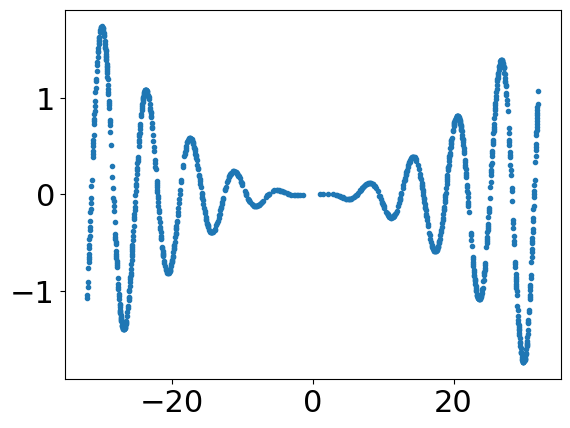

In [2]:
tmp = np.load('data/sq_sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
plt.plot(trX, trY, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False, drop_last=False)
epochs = 300
milestones = [100, 200]

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GAR = []

alpha = 0.5

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha, version='GAR')
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR.append(pred_Y)
    
preds_GAR = np.concatenate(preds_GAR, axis=1)

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_RNC = []

for seed in seeds:
    set_all_seeds(seed)
    RNC = RnCLoss(temperature=4)
    basic_loss = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, feat = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            if epoch < 100:
                loss = RNC(feat, tr_Y)
            else:
                loss = basic_loss(pred_Y, tr_Y)
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, feat = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, feat = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='RNC')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='RNC')
    plt.legend()

    preds_RNC.append(pred_Y)
    
preds_RNC = np.concatenate(preds_RNC, axis=1)

In [ ]:
lr = 0.01
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    
preds_Pearson = np.concatenate(preds_Pearson, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    
preds_MAE = np.concatenate(preds_MAE, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    
preds_MSE = np.concatenate(preds_MSE, axis=1)

In [ ]:
np.savez('data/sq_sine_results.npz', preds_GAR=preds_GAR, preds_RNC=preds_RNC, preds_Pearson=preds_Pearson, preds_MAE=preds_MAE, preds_MSE=preds_MSE)

In [ ]:
tmp = np.load('data/sq_sine_results.npz')
MSE, MAE, APearson, RNC, GAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_GAR']

mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
print(mean_MSE)
print(std_MSE)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_MSE.pdf',format='pdf')


mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_MAE.pdf',format='pdf')


mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_APearson.pdf',format='pdf')


mean_GAR = GAR.mean(axis=1)
std_GAR = GAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label='GAR')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_GAR.pdf',format='pdf')


mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_RNC.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_GAR, '--', label='GAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figures/sq_sin_all_mean_cmp.pdf',format='pdf')

# Directly load the pre-executed results without running by yourself

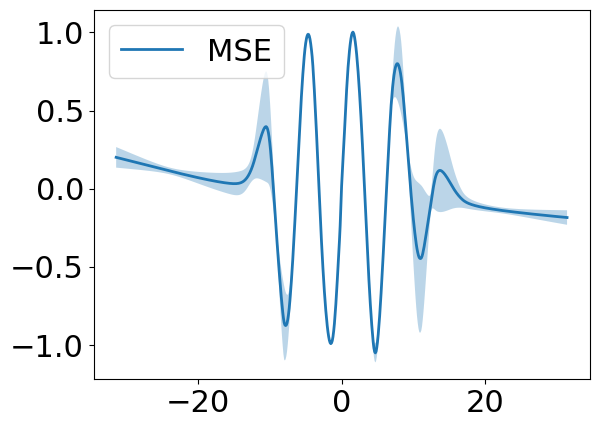

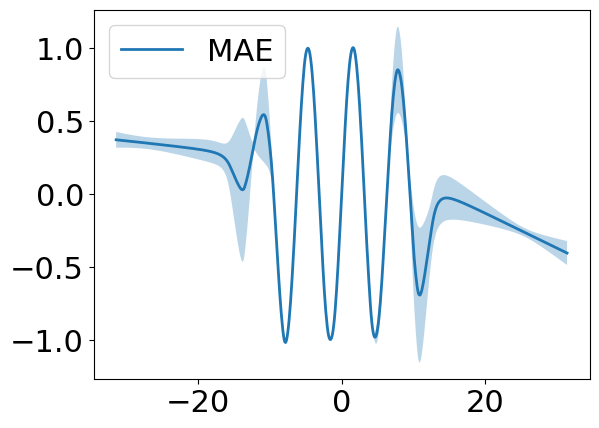

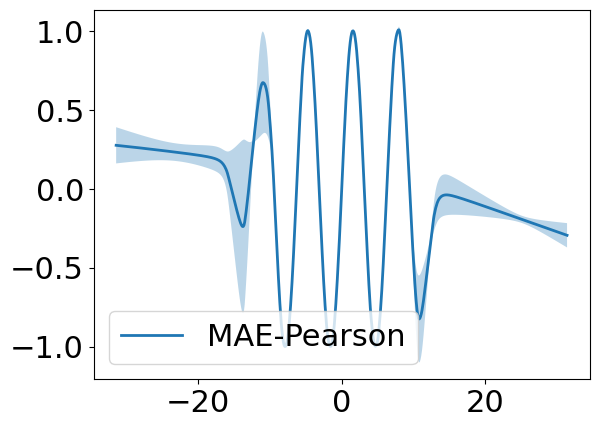

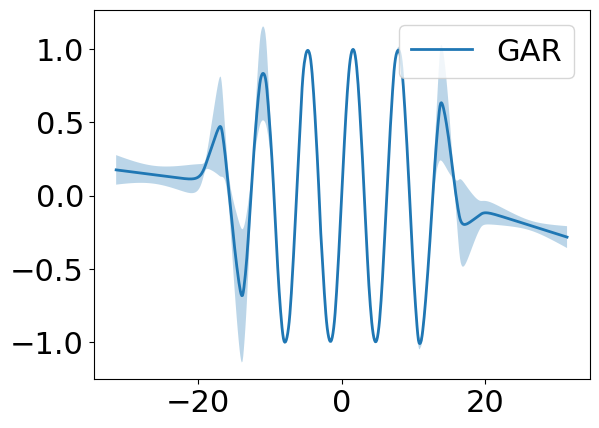

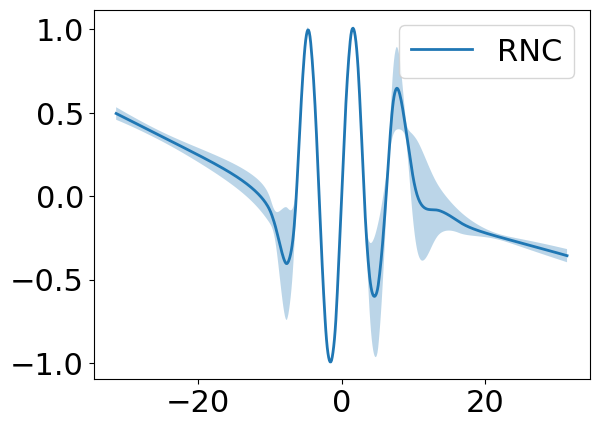

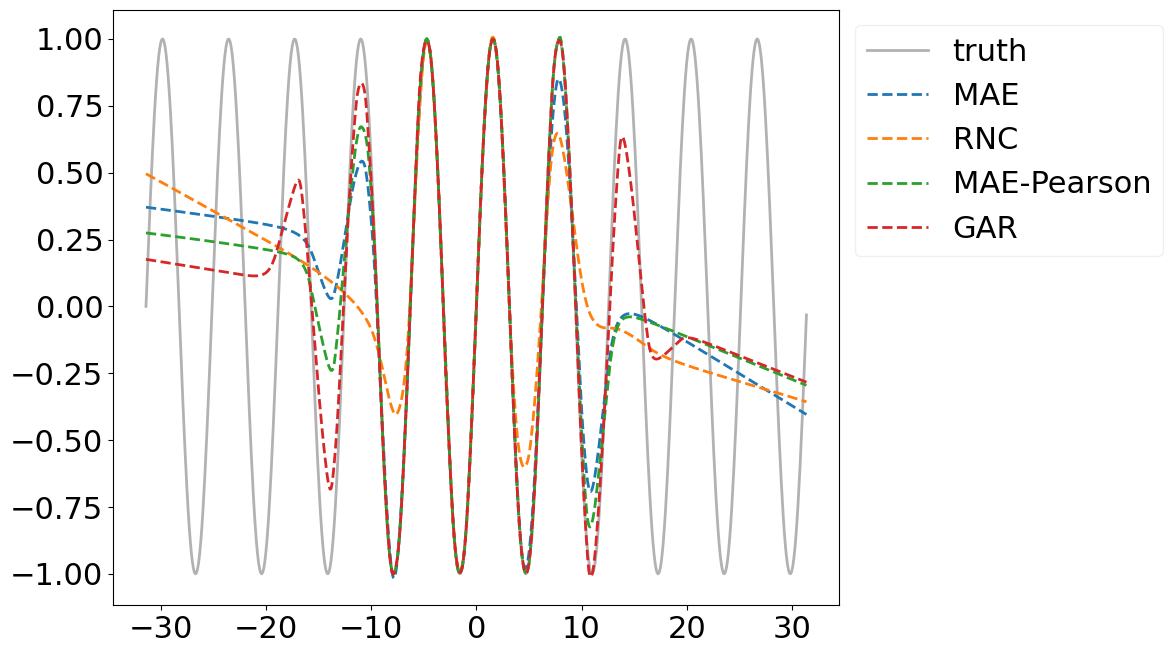

In [4]:
tmp = np.load('data/sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']


tmp = np.load('data/sine_results.npz')
MSE, MAE, APearson, RNC, GAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_GAR']
mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()



mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()



mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()


mean_GAR = GAR.mean(axis=1)
std_GAR = GAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label='GAR')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.legend()


mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_GAR, '--', label='GAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()


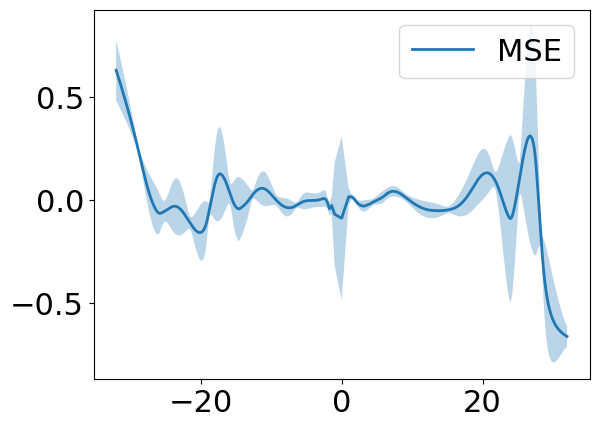

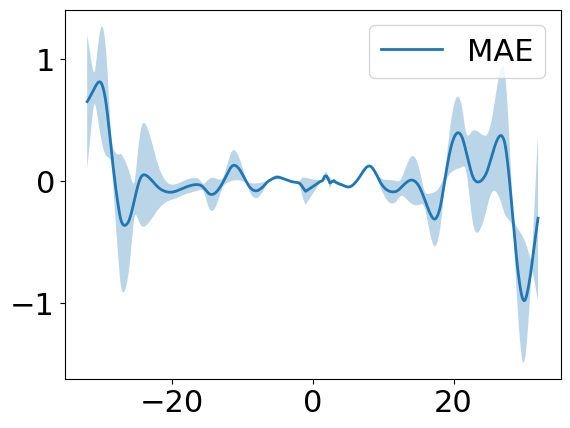

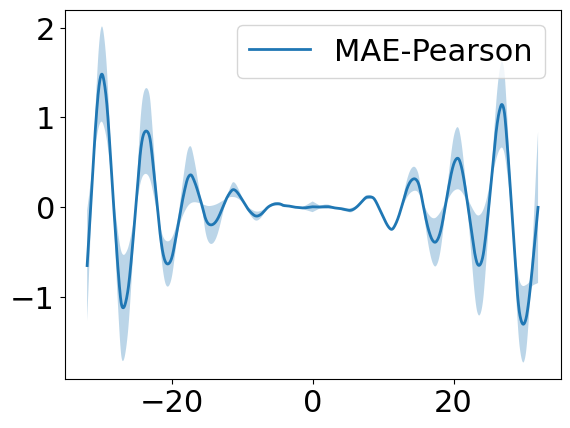

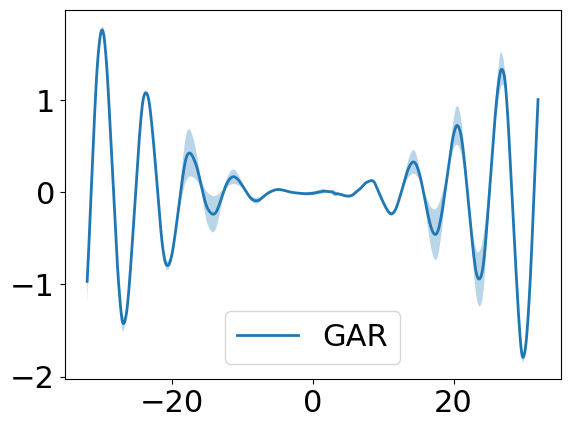

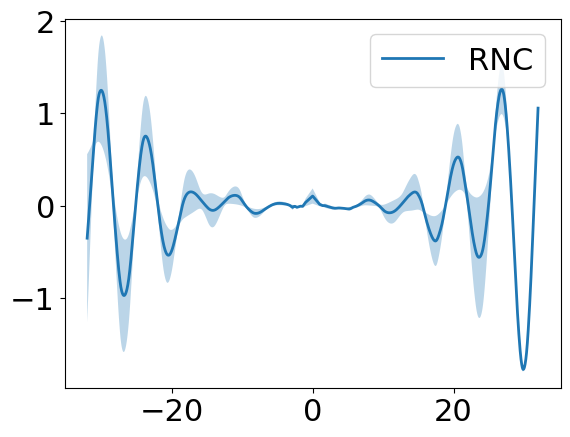

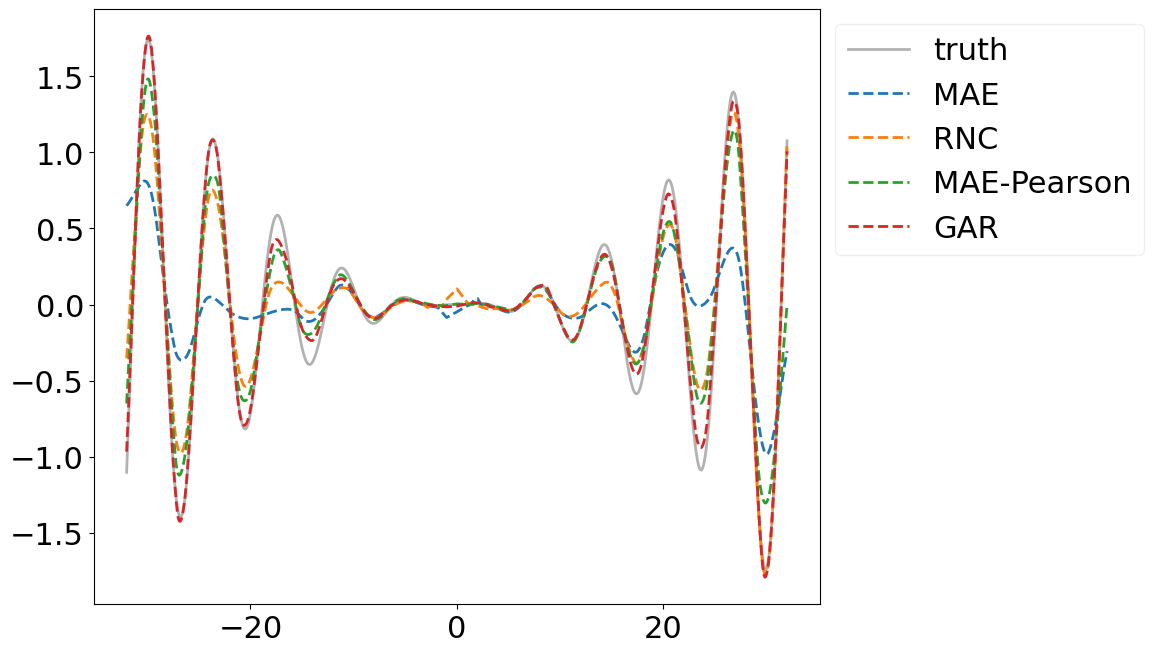

In [5]:
tmp = np.load('data/sq_sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']


tmp = np.load('data/sq_sine_results.npz')
MSE, MAE, APearson, RNC, GAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_GAR']


mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()



mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()



mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()


mean_GAR = GAR.mean(axis=1)
std_GAR = GAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label='GAR')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.legend()


mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_GAR, '--', label='GAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
